# Introduction

The goal of this project is to build a machine learning model that predicts which Tweets are about real disasters and which one's aren't. This sentiment classification task is important for helping first responders and news organizations detect and respond to real disasters quickly.

In [88]:
# Important libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data Cleaning and Preprocessing
from sklearn.utils import resample
import re
import nltk.corpus
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Model Building and Training
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras import layers, Model, Sequential
from tensorflow.keras.layers import Input, Dense, Embedding, Concatenate, StringLookup, Dropout, Flatten, LSTM, Bidirectional
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.keras import backend as K

# Results and Evaluation
from sklearn.metrics import confusion_matrix


# Data
The dataset was obtained from the Kaggle competition page [3]. The training dataset consists of 7,613 tweets each of which is hand classified with either a 1 representing a real disaster or 0 representing not-real disaster. The tweets each have a unique id and three features: text, keyword (possibly blank), and the location of the tweet (possibly blank). The tweet feature is a string which can be seen as a sequence of words. The test dataset contains 3,263 tweets with the same features but no labels. All the tweets are in English

In [4]:
train_df = pd.read_csv('train.csv')
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None


In [5]:
test_df = pd.read_csv('test.csv')
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB
None


# Exploratory Data Analysis
I will look at some example tweets and create some visualizations of the training dataset to inform my plan of creating a machine learning model.

In [6]:
sample_disaster_tweets = train_df[train_df['target']==1].head(5)
print(np.array(sample_disaster_tweets['text']))

['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'
 'Forest fire near La Ronge Sask. Canada'
 "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected"
 '13,000 people receive #wildfires evacuation orders in California '
 'Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school ']


The five sample tweets about real disasters all contain capital letters, punctuation, numbers, and stopwords. Typically, natural language processing removes all of these from the text before training the model. Two of the tweets, however, contain a hashtag with the name of of a natural disaster. It may be worth considering hashtags separately rather than removing them with other punctuation marks.

In [7]:
sample_nondisaster_tweets = train_df[train_df['target']==0]['text'].head(5)
print(np.array(sample_nondisaster_tweets))

["What's up man?" 'I love fruits' 'Summer is lovely' 'My car is so fast'
 'What a goooooooaaaaaal!!!!!!']


The five sample non-disaster tweets also contain capital letters, punctuation, and stop words. The non-disaster tweets seem pretty innocuous, with feature extraction my model should be able to classify tweets related to disasters. 

In [8]:
disaster_tweets_with_keywords = train_df[(train_df['target']==1)&(train_df['keyword'].notna())].head(5)
print(np.array(disaster_tweets_with_keywords['text']))
print(np.array(disaster_tweets_with_keywords['keyword']))
print(np.array(disaster_tweets_with_keywords['location']))

['@bbcmtd Wholesale Markets ablaze http://t.co/lHYXEOHY6C'
 '#AFRICANBAZE: Breaking news:Nigeria flag set ablaze in Aba. http://t.co/2nndBGwyEi'
 'INEC Office in Abia Set Ablaze - http://t.co/3ImaomknnA'
 'Barbados #Bridgetown JAMAICA \x89ÛÒ Two cars set ablaze: SANTA CRUZ \x89ÛÓ Head of the St Elizabeth Police Superintende...  http://t.co/wDUEaj8Q4J'
 'How the West was burned: Thousands of wildfires ablaze in California alone http://t.co/vl5TBR3wbr']
['ablaze' 'ablaze' 'ablaze' 'ablaze' 'ablaze']
['Birmingham' 'AFRICA' 'World Wide!!' nan 'GREENSBORO,NORTH CAROLINA']


In [9]:
nondisaster_tweets_with_keywords = train_df[(train_df['target']==0)&(train_df['keyword'].notna())].head(5)
print(np.array(nondisaster_tweets_with_keywords['text']))
print(np.array(nondisaster_tweets_with_keywords['keyword']))
print(np.array(nondisaster_tweets_with_keywords['location']))

['We always try to bring the heavy. #metal #RT http://t.co/YAo1e0xngw'
 'Crying out for more! Set me ablaze'
 'On plus side LOOK AT THE SKY LAST NIGHT IT WAS ABLAZE http://t.co/qqsmshaJ3N'
 "@PhDSquares #mufc they've built so much hype around new acquisitions but I doubt they will set the EPL ablaze this season."
 'Ablaze for you Lord :D']
['ablaze' 'ablaze' 'ablaze' 'ablaze' 'ablaze']
['Est. September 2012 - Bristol' 'Philadelphia, PA' 'London, UK'
 'Pretoria' 'Paranaque City']


Comparing disaster tweets with nondisaster tweets for the keyword 'ablaze' reveals more about necessary NLP steps and the differences between the two categories. Some of the tweets have URLs which will need to be removed as part of data cleaning. The disaster tweets in these examples contain location names in the text much more commonly. Both categories contain location features.

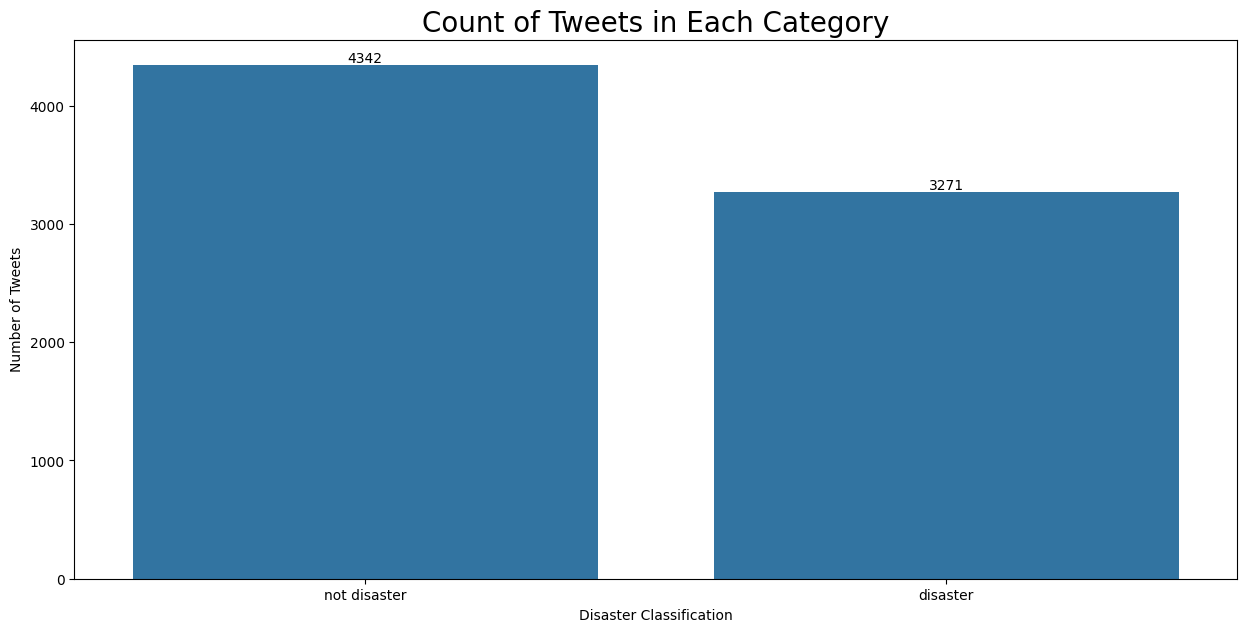

In [10]:
# Compare the frequency of the two categories
plt.figure(figsize=(15,7))
ax = sns.countplot(data=train_df , x=train_df['target'])

plt.xlabel('Disaster Classification')
plt.ylabel('Number of Tweets')
plt.xticks(ticks=[0,1], labels=['not disaster', 'disaster'])
plt.title('Count of Tweets in Each Category', fontsize=20)
ax.bar_label(ax.containers[0])
plt.show()

The two categories are imbalanced. This could cause our model to be biased towards the not disaster category. It could also cause metrics such as accuracy to be misleading. To mitigate these issues the categories can be rebalanced using one of a few strategies:
* Resampling: undersample the majority class and/or oversample the minority class
* Synthetic Minority Oversampling Technique (SMOTE)  

SMOTE requires numerical data so it cannot be used for this task. Oversampling using simple observation duplication can lead to a model with poor generalization. While undersampling could remove valuable data it reduces training time and simplifies the model so it will be used to balance the classes.

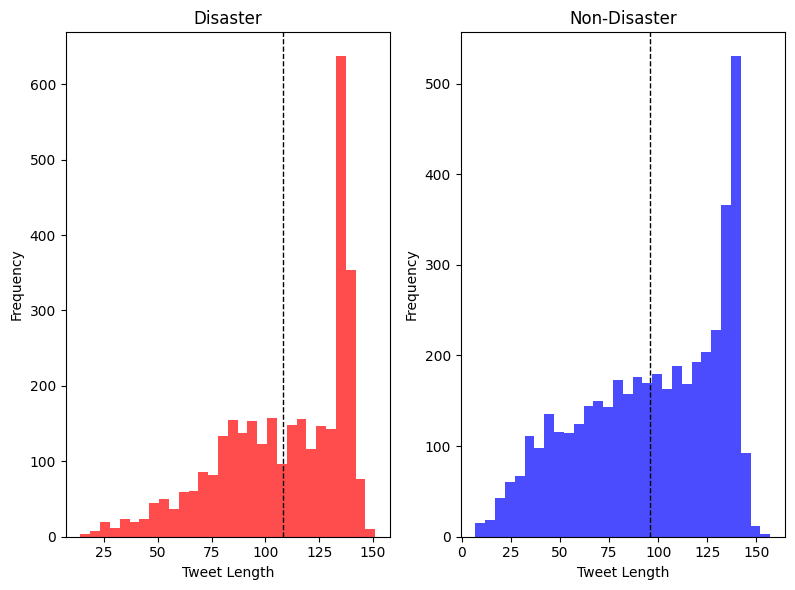

In [11]:
disaster_len = train_df[train_df['target']==1]['text'].apply(len)
mean_disaster_len = np.mean(disaster_len, axis=0)

nondisaster_len = train_df[train_df['target']==0]['text'].apply(len)
mean_nondisaster_len = np.mean(nondisaster_len, axis=0)

plt.figure(figsize=(12, 6))

# Plot histogram of disaster tweet lengths
plt.subplot(1, 3, 1)
plt.hist(disaster_len, bins=30, color='r', alpha=0.7)
plt.axvline(mean_disaster_len, color='k', linestyle='dashed', linewidth=1)
plt.title('Disaster')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')

# Plot histogram of nondisaster tweet lengths
plt.subplot(1, 3, 2)
plt.hist(nondisaster_len, bins=30, color='b', alpha=0.7)
plt.axvline(mean_nondisaster_len, color='k', linestyle='dashed', linewidth=1)
plt.title('Non-Disaster')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

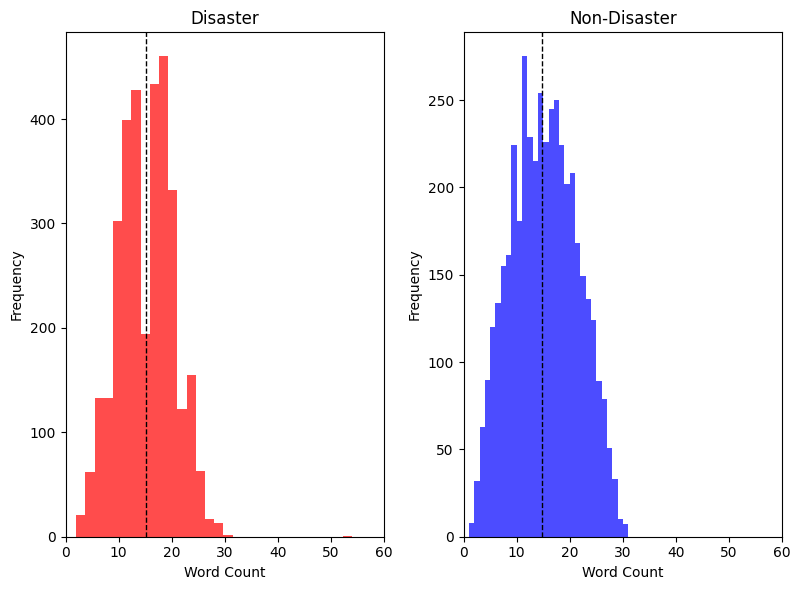

In [12]:
def get_word_count(tweet: str) -> int:
    return len(tweet.split(' '))

disaster_word_counts = train_df[train_df['target']==1]['text'].apply(get_word_count)
mean_disaster_word_count = np.mean(disaster_word_counts, axis=0)

nondisaster_word_counts = train_df[train_df['target']==0]['text'].apply(get_word_count)
mean_nondisaster_word_count = np.mean(nondisaster_word_counts, axis=0)

plt.figure(figsize=(12, 6))

# Plot histogram of disaster word counts
plt.subplot(1, 3, 1)
plt.hist(disaster_word_counts, bins=30, color='r', alpha=0.7)
plt.axvline(mean_disaster_word_count, color='k', linestyle='dashed', linewidth=1)
plt.title('Disaster')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.xlim(0, 60)

# Plot histogram of nondisaster word counts
plt.subplot(1, 3, 2)
plt.hist(nondisaster_word_counts, bins=30, color='b', alpha=0.7)
plt.axvline(mean_nondisaster_word_count, color='k', linestyle='dashed', linewidth=1)
plt.title('Non-Disaster')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.xlim(0, 60)

plt.tight_layout()
plt.show()

# Data Cleaning and Preprocessing

In [13]:
# Balance the classes
majority_class = train_df[train_df['target']==0]
minority_class = train_df[train_df['target']==1]

# undersample majority class
majority_class_downsampled = resample(majority_class,
                                      replace=False,
                                      n_samples=len(minority_class),
                                      random_state=42)

balanced_df = pd.concat([majority_class_downsampled, minority_class])

print(balanced_df['target'].value_counts())

target
0    3271
1    3271
Name: count, dtype: int64


In [15]:
def remove_punctuation(text: str) -> str:
    punctuation_free=re.sub(r'[^\w\s]+', '', text)
    return punctuation_free


def tokenize_text(text: str) -> str:
    tokens = text.split(' ')
    return tokens

def remove_stopwords(text: str) -> str:
    words_for_removal = stopwords.words('english')
    words_for_removal.append('')
    stopword_free = [word for word in text if word not in words_for_removal]
    return stopword_free

def remove_url(text: str) -> str:
    return re.sub(r'http\S+', '', text)

lowercase = train_df['text'].str.lower()
url_free = lowercase.apply(remove_url)
punctuation_free = url_free.apply(remove_punctuation)
tokenized_tweets = punctuation_free.apply(tokenize_text)
stopword_free = tokenized_tweets.apply(remove_stopwords)

stopword_free.head()

0    [deeds, reason, earthquake, may, allah, forgiv...
1        [forest, fire, near, la, ronge, sask, canada]
2    [residents, asked, shelter, place, notified, o...
3    [13000, people, receive, wildfires, evacuation...
4    [got, sent, photo, ruby, alaska, smoke, wildfi...
Name: text, dtype: object

Data cleaning so far has included punctuation removal, url removal, lowering all uppercase letters, and tokenization. For the final data cleaning step I will standardize the words used in each tweet. There are two commonly used options for standardization: stemming and lemmatization. Stemming reduces words to their base for example running -> run. Stemming can cause some words to lose their meaning for example available -> avail. For this project I will use lemmatization which also reduces words to their base but uses a pre-defined dictionary of words to ensure meaning is not lost. 

There are some other preprocessing steps such as HTML tag and rare word removal that are not necessary due to the context of the data (tweets).

In [17]:
wordnet_lemmatizer = WordNetLemmatizer()
def lemmatizer(text: str) -> str:
    lemm_text = [wordnet_lemmatizer.lemmatize(word) for word in text]
    return lemm_text
train_df['lemm_text'] = stopword_free.apply(lambda x: lemmatizer(x))
train_df['lemm_text'].head()

0    [deed, reason, earthquake, may, allah, forgive...
1        [forest, fire, near, la, ronge, sask, canada]
2    [resident, asked, shelter, place, notified, of...
3    [13000, people, receive, wildfire, evacuation,...
4    [got, sent, photo, ruby, alaska, smoke, wildfi...
Name: lemm_text, dtype: object

In [19]:
# Impute missing values for keyword and location
train_df['keyword'] = train_df['keyword'].fillna('missing')
train_df['location'] = train_df['location'].fillna('missing')

# Model Building and Training
I will use tensorflow's TextVectorization layer. This class has a standardize method but it cannot remove urls so I standardized the text myself prior to passing it to TextVectorization.  The required input is a sequence of words so I will join my lemmatized lists back into strings. I chose 30 words as the sequence length based on the graphs of word count seen above

In [20]:
train_copy = train_df.copy()
clean_text = train_copy['lemm_text'].apply(lambda x: ' '.join(x))
train_df['text'] = clean_text
train_df.drop(['lemm_text'], axis=1, inplace=True)
train_df.head()

,id,keyword,location,text,target
0,1,missing,missing,deed reason earthquake may allah forgive u,1
1,4,missing,missing,forest fire near la ronge sask canada,1
2,5,missing,missing,resident asked shelter place notified officer ...,1
3,6,missing,missing,13000 people receive wildfire evacuation order...,1
4,7,missing,missing,got sent photo ruby alaska smoke wildfire pour...,1


In [21]:
# Split training and validation datasets, test data is already in separate dataframe
X_train, X_val, y_train, y_val = train_test_split(
    train_df[['text', 'keyword', 'location']],
    train_df['target'],
    test_size=0.2,
    random_state=42
)

In [22]:
# Vectorize layer to vectorize the main text of the tweet
max_features = 10000
sequence_length = 30

vectorize_layer = layers.TextVectorization(
    standardize=None,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [23]:
# Create tensorflow dataset
train_text_ds = tf.data.Dataset.from_tensor_slices(X_train['text'].values)

# adapt vectorization layer to train set only to prevent data leakage
vectorize_layer.adapt(train_text_ds)

In [24]:
vectorized_train_text = vectorize_layer(X_train['text'].values)
vectorized_val_text = vectorize_layer(X_val['text'].values)

I chose StringLookup instead of other encoding options like one-hot encoding or tf-idf because I plan on feeding the output through an Embedding layer to create a dense vector representation

In [25]:
# Convert categorical string features into integer IDs
keyword_encoder = StringLookup(vocabulary=X_train['keyword'].unique(), mask_token=None)
location_encoder = StringLookup(vocabulary=X_train['location'].unique(), mask_token=None)

encoded_train_keyword = keyword_encoder(X_train['keyword'].values)
encoded_val_keyword = keyword_encoder(X_val['keyword'].values)

encoded_train_location = keyword_encoder(X_train['location'].values)
encoded_val_location = keyword_encoder(X_val['location'].values)

In [26]:
# Prepare train and validation datasets for model training
train_data = tf.data.Dataset.from_tensor_slices(({
    'text': vectorized_train_text,
    'keyword': encoded_train_keyword,
    'location': encoded_train_location
}, y_train))

val_data = tf.data.Dataset.from_tensor_slices(({
    'text': vectorized_val_text,
    'keyword': encoded_val_keyword,
    'location': encoded_val_location
}, y_val))

# Define batch size and shuffle for training
train_data = train_data.shuffle(buffer_size=len(X_train)).batch(32)
val_data = val_data.batch(32)

For my model architecture I considered Gated Recurrent Units (GRU) and Long Short-Term Memory units (LSTM) both of which are well suited to handling sequential data like text. GRU is more computationally efficient than LSTM so I will use GRU for processing the text portion of the dataset. In order to concatenate the the location and keyword embeddings with GRU output they need to be flattened to a 1D vector for compatibility. I use one fully integrated layer for processing the combined dataset (text, keyword, and location) because a fully connected layer is well suited to processing 1D vectors.

In [77]:
# Define inputs
text_input = Input(shape=(sequence_length,), name='text')
keyword_input = Input(shape=(1,), name='keyword')
location_input = Input(shape=(1,), name='location')

# Embedding layers
embedding_layer = Embedding(input_dim=max_features, output_dim=1000, input_length=30)(text_input)

# Default parameters meet requirements for cuDNN implementation (GPU)
gru_layer = layers.GRU(
    256,
    return_sequences=False
)(embedding_layer)

keyword_embedding = Embedding(input_dim=222, output_dim=100)(keyword_input)
location_embedding = Embedding(input_dim=3342, output_dim=300)(location_input)

# Flatten embeddings
keyword_flattened = Flatten()(keyword_embedding)
location_flattened = Flatten()(location_embedding)

# Concatenate features
concatenated = layers.Concatenate()([gru_layer, keyword_flattened, location_flattened])

# Dense layers and output
dense_layer = Dense(256, activation='relu')(concatenated)
dropout_1 = Dropout(0.5, seed=42)(dense_layer)
dense_layer_2 = Dense(128, activation='relu')(dropout_1)
dropout_2 = Dropout(0.5, seed=42)(dense_layer_2)
dense_layer_3 = Dense(64, activation='relu')(dropout_2)
dropout_3 = Dropout(0.5, seed=42)(dense_layer_3)

output = Dense(1, activation='sigmoid')(dropout_3)

# Define the model
model = Model(inputs=[text_input, keyword_input, location_input], outputs=output)

# Tensorflow does not have F1 so write my own
def f1_score(y_true, y_pred):
    # Convert probabilities to class labels
    y_pred = K.round(y_pred)
    
    # Calculate true positives, false positives, and false negatives
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    fp = K.sum(K.round(K.clip(y_pred - y_true, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))
    
    # Calculate precision and recall
    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())
    
    # Calculate F1 score
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
    
    return f1

# Compile the model
model.compile(optimizer=Nadam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy', f1_score])

model.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None, 30)]         0           []                               
                                                                                                  
 keyword (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 location (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 embedding_30 (Embedding)       (None, 30, 1000)     10000000    ['text[0][0]']                   
                                                                                           

The model was optimized by using the Nadam optimizer. Nadam is Adam with Nesterov momentum. This optimizer squashes the learning rate based on the current loss gradient. It also uses momentum to help the model escape local minima in the loss gradient. Binary cross entropy was used as the loss function to match the goal of binary sentiment classification of tweets.

Regularization was done through early stopping.

In [66]:
early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

In [67]:
# Training the model
history = model.fit(train_data,
                    validation_data=val_data,
                    epochs=200,
                    callbacks=[early_stop_callback])

Epoch 1/200
191/191 [==============================] - 6s 19ms/step - loss: 0.6921 - accuracy: 0.5271 - f1_score: 0.4016 - val_loss: 0.6896 - val_accuracy: 0.5739 - val_f1_score: 0.0000e+00
Epoch 2/200
191/191 [==============================] - 3s 17ms/step - loss: 0.6897 - accuracy: 0.5422 - f1_score: 0.1828 - val_loss: 0.6859 - val_accuracy: 0.5739 - val_f1_score: 0.0000e+00
Epoch 3/200
191/191 [==============================] - 3s 17ms/step - loss: 0.6870 - accuracy: 0.5568 - f1_score: 0.1083 - val_loss: 0.6838 - val_accuracy: 0.5739 - val_f1_score: 0.0000e+00
Epoch 4/200
191/191 [==============================] - 3s 17ms/step - loss: 0.6866 - accuracy: 0.5637 - f1_score: 0.0868 - val_loss: 0.6828 - val_accuracy: 0.5739 - val_f1_score: 0.0000e+00
Epoch 5/200
191/191 [==============================] - 3s 16ms/step - loss: 0.6862 - accuracy: 0.5668 - f1_score: 0.0700 - val_loss: 0.6825 - val_accuracy: 0.5739 - val_f1_score: 0.0000e+00
Epoch 6/200
191/191 [=============================

dict_keys(['loss', 'accuracy', 'f1_score', 'val_loss', 'val_accuracy', 'val_f1_score'])
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07367656379938126, 0.07367656379938126, 0.16352002322673798, 0.21445010602474213, 0.28453290462493896, 0.29796165227890015, 0.38052430748939514, 0.38052430748939514, 0.4014705419540405, 0.4313918650150299, 0.3721581995487213, 0.5038483142852783, 0.48106029629707336, 0.5789865851402283, 0.5906731486320496, 0.6084476709365845, 0.5904884934425354, 0.5749943852424622, 0.6150370240211487, 0.6155034303665161, 0.6231738924980164, 0.6316643953323364, 0.6389684081077576, 0.6231738924980164, 0.6471315026283264, 0.6404872536659241, 0.6436715126037598, 0.6436715126037598, 0.6392719745635986, 0.6436715126037598, 0.6436715126037598, 0.6442256569862366, 0.6466028094291687, 0.6452040076255798, 0.

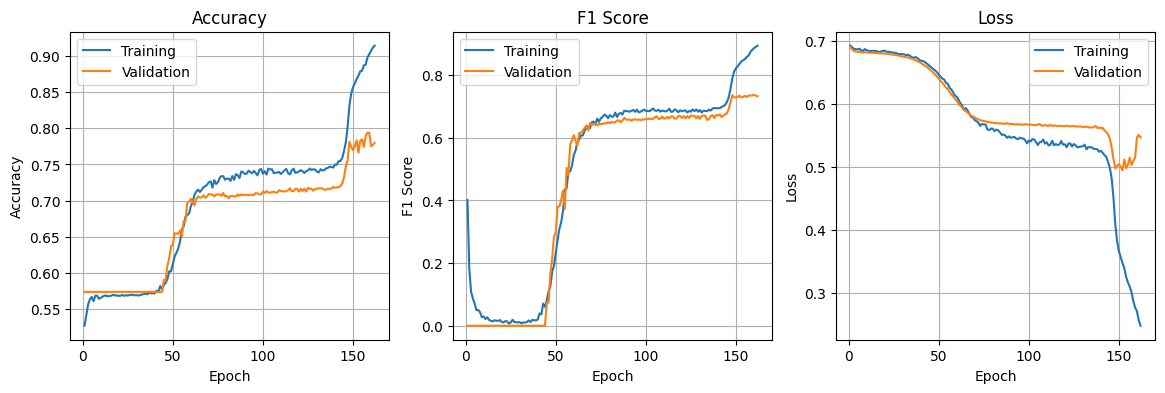

In [68]:
h = history.history
print(h.keys())
epoch_range = range(1, len(h['loss'])+1)

plt.figure(figsize=[14,4])
n = int(len(h.keys()) / 2)

# Plot accuracy
plt.subplot(1,3,1)
plt.plot(epoch_range, h['accuracy'], label='Training')
plt.plot(epoch_range, h['val_accuracy'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy')
plt.grid()
plt.legend()

# Plot F1
plt.subplot(1,3,2)
plt.plot(epoch_range, h['f1_score'], label='Training')
plt.plot(epoch_range, h['val_f1_score'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('F1 Score'); plt.title('F1 Score')
plt.grid()
plt.legend()

# Plot Loss
plt.subplot(1,3,3)
plt.plot(epoch_range, h['loss'], label='Training')
plt.plot(epoch_range, h['val_loss'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss')
plt.grid()
plt.legend()

print(h['val_f1_score'])

In [70]:
# Create clean dataset for test data
test_lowercase = test_df['text'].str.lower()
test_url_free = test_lowercase.apply(remove_url)
test_punctuation_free = test_url_free.apply(remove_punctuation)
test_tokenized_tweets = test_punctuation_free.apply(tokenize_text)
test_stopword_free = test_tokenized_tweets.apply(remove_stopwords)
test_df['lemm_text'] = test_stopword_free.apply(lambda x: lemmatizer(x))

# Impute missing values for keyword and location
test_df['keyword'] = test_df['keyword'].fillna('missing')
test_df['location'] = test_df['location'].fillna('missing')

test_copy = test_df.copy()
test_clean_text = test_copy['lemm_text'].apply(lambda x: ' '.join(x))
train_df['text'] = test_clean_text
test_df.drop(['lemm_text'], axis=1, inplace=True)
test_df.head()

,id,keyword,location,text
0,0,missing,missing,Just happened a terrible car crash
1,2,missing,missing,"Heard about #earthquake is different cities, s..."
2,3,missing,missing,"there is a forest fire at spot pond, geese are..."
3,9,missing,missing,Apocalypse lighting. #Spokane #wildfires
4,11,missing,missing,Typhoon Soudelor kills 28 in China and Taiwan


In [80]:
# Prepare test data in the same way training and validation data were prepared
vectorized_test_text = vectorize_layer(test_df['text'].values)

encoded_test_keyword = keyword_encoder(test_df['keyword'].values)
encoded_test_location = location_encoder(test_df['location'].values)

test_data = tf.data.Dataset.from_tensor_slices(({
    'text': vectorized_test_text,
    'keyword': encoded_test_keyword,
    'location': encoded_test_location
}))

test_data = test_data.batch(32)

In [81]:
# Create predictions of the test data for submission to Kaggle competition
predictions = model.predict(test_data)

102/102 [==============================] - 1s 4ms/step


In [85]:
# Convert numpy array of predictions to format specified by sample submission
predicted_labels = (predictions > 0.5).astype(int)
test_df['target'] = predicted_labels
submission_df = test_df.drop(['keyword', 'location', 'text', 'label'], axis=1)
print(submission_df.head())
submission_df.to_csv('submission.csv', index=False)

   id  target
0   0       0
1   2       0
2   3       0
3   9       0
4  11       0


# Results and Analysis
Initially, with a learning rate of 0.001 the model only took a minute to train on an NVIDIA GeForce 2070 Super. After decreasing the learning rate to 0.00001, increasing the number of layers, and increasing the number of filters per layer the model still only took 10 minutes to train. This runtime could be improved by setting GPU memory growth at program startup, using a more powerful GPU, or using a GPU server.

For this project I performed tuning of hyperparameters and the model architecture manually. I started with a learning rate of 0.001 and achieved a validation F1 score of 0.720 with significant evidence of overfitting during the later epochs. Since the model trained faster than expected I increased GRU layers to 256, greatly increased the output dimensions of my embedding layers, decreased the learning rate to 0.0001, and added a dropout layer to mitigate overfitting. The validation score decreased after these measures to 0.61. Next I added another dense layer and another dropout layer and reduced the learning rate to 0.00001 to compensate for the reduction in parameters due to the dropout layer. This increased validation F1 score to 0.751 after 98 epochs. Finally, I tried adding another dense layer and another dropout layer but the validation f1 score remained around the same at 0.736. The final hyperparemeters and the resulting performance can be seen above.

The test F1 score was 0.57 indicating overfitting when compared with the validation F1 score of 0.736 and even higher training F1 score. Some regularization strategies such as dropout and early stopping were implemented to mitigate overfitting but more strategies could be employed to improve the model. 

The metrics all proceeded with step-wise improvements through the epochs as seen by the S shapes in the graphs. One theory is that the model initially only uses word frequencies to classify sentiment which results in a loss plateau. Once the model learns enough about the data to use context to classify sentiment loss begins to improve again. [7]

Next I will compare my GRU model with LSTM using the recommended architecture by tensorflow. [8] I am also going to leave the keywords and locations off when training this model.


In [90]:
# Compare GRU with LSTM
# Prepare train and validation datasets for model training
train_data2 = tf.data.Dataset.from_tensor_slices(({
    'text': vectorized_train_text
}, y_train))

val_data2 = tf.data.Dataset.from_tensor_slices(({
    'text': vectorized_val_text
}, y_val))

# Define batch size and shuffle for training
train_data2 = train_data2.shuffle(buffer_size=len(X_train)).batch(32)
val_data2 = val_data2.batch(32)


model2 = Sequential([
    Input(shape=(sequence_length,), name='text'),
    Embedding(input_dim=max_features, output_dim=1000, input_length=30),
    Bidirectional(LSTM(64)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
model2.compile(optimizer=Nadam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy', f1_score])
history = model2.fit(train_data2,
                    validation_data=val_data2,
                    epochs=200,
                    callbacks=[early_stop_callback])


Epoch 1/200
191/191 [==============================] - 7s 21ms/step - loss: 0.6864 - accuracy: 0.5650 - f1_score: 0.0652 - val_loss: 0.6795 - val_accuracy: 0.5739 - val_f1_score: 0.0000e+00
Epoch 2/200
191/191 [==============================] - 3s 18ms/step - loss: 0.6787 - accuracy: 0.5695 - f1_score: 0.0000e+00 - val_loss: 0.6737 - val_accuracy: 0.5739 - val_f1_score: 0.0000e+00
Epoch 3/200
191/191 [==============================] - 3s 18ms/step - loss: 0.6734 - accuracy: 0.5695 - f1_score: 0.0000e+00 - val_loss: 0.6679 - val_accuracy: 0.5739 - val_f1_score: 0.0000e+00
Epoch 4/200
191/191 [==============================] - 4s 19ms/step - loss: 0.6674 - accuracy: 0.5695 - f1_score: 0.0000e+00 - val_loss: 0.6615 - val_accuracy: 0.5739 - val_f1_score: 0.0000e+00
Epoch 5/200
191/191 [==============================] - 3s 18ms/step - loss: 0.6595 - accuracy: 0.5722 - f1_score: 0.0120 - val_loss: 0.6525 - val_accuracy: 0.5798 - val_f1_score: 0.0278
Epoch 6/200
191/191 [=====================

dict_keys(['loss', 'accuracy', 'f1_score', 'val_loss', 'val_accuracy', 'val_f1_score'])
[0.0, 0.0, 0.0, 0.0, 0.027786044403910637, 0.18073397874832153, 0.3137354552745819, 0.4089319705963135, 0.5135489702224731, 0.5382658839225769, 0.6016994118690491, 0.6599236130714417, 0.6441925168037415, 0.6717422604560852, 0.660384476184845, 0.70846027135849, 0.7130196690559387, 0.7341790199279785, 0.7270582318305969, 0.7305013537406921, 0.7370144724845886, 0.7366665005683899, 0.730772078037262, 0.7314305901527405, 0.7343013286590576, 0.7333837151527405, 0.7528684139251709, 0.7467114925384521, 0.7316318154335022, 0.7410683035850525]


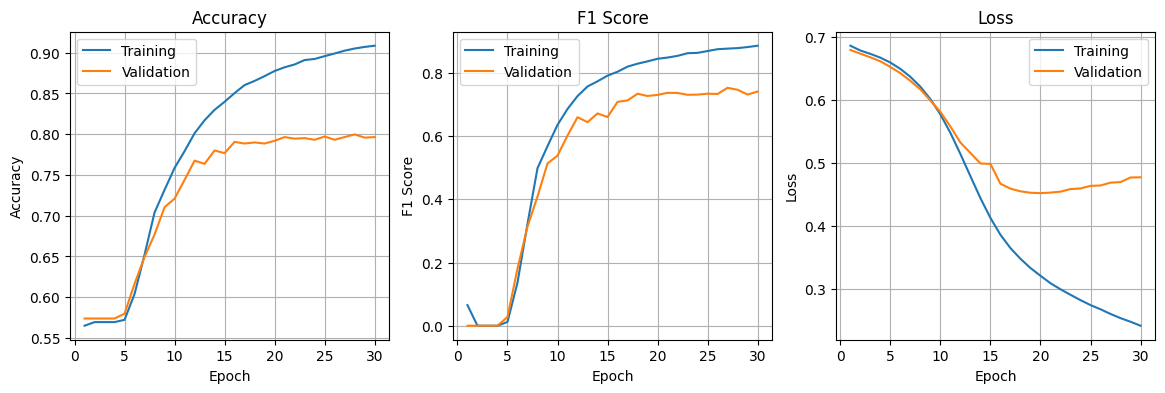

In [91]:
h = history.history
print(h.keys())
epoch_range = range(1, len(h['loss'])+1)

plt.figure(figsize=[14,4])
n = int(len(h.keys()) / 2)

# Plot accuracy
plt.subplot(1,3,1)
plt.plot(epoch_range, h['accuracy'], label='Training')
plt.plot(epoch_range, h['val_accuracy'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy')
plt.grid()
plt.legend()

# Plot F1
plt.subplot(1,3,2)
plt.plot(epoch_range, h['f1_score'], label='Training')
plt.plot(epoch_range, h['val_f1_score'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('F1 Score'); plt.title('F1 Score')
plt.grid()
plt.legend()

# Plot Loss
plt.subplot(1,3,3)
plt.plot(epoch_range, h['loss'], label='Training')
plt.plot(epoch_range, h['val_loss'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss')
plt.grid()
plt.legend()

print(h['val_f1_score'])

# Conclusion and Discussion
The LSTM model performed similarly to the GRU model achieving a validation F1 score of 0.753. Early stopping caused the training to stop after only 30/200 epochs. With a lower learning rate and more regularization the performance of the LSTM model could be improved. The runtime was similar even though the LSTM model had much fewer layers. This reflects the computational simplicity of GRU. Curiously, the best performing model was the LSTM model which didn't include keywords and locations at all. These additional features added complexity to the GRU architecture and may not have improved the performance. 

While I was able to tune the hyperparameters and architecture of my model I was not able to achieve an F1 score above 0.80. There are some additional strategies that could be used to improve this model in the future.

Overfitting is a concern as neural networks learn more about the training data. While training loss typically decreases throughout the training process, validation loss can reach a minimum then increase signifying overfitting. To protect against overfitting I used an early stopping callback and dropouts. This callback uses a copy of the model to save the best parameters during the training process, even if those parameters occur earlier in the process. The callback also stops the training process if validation loss does not improve for five epochs in a row. 

To further protect against overfitting the model could be improved through more regularization. Additional strategies include L2 Regularization and batch normalization.

Another way to improve the model would be a more complex method of balancing the classes. I used random undersampling of the majority class which can remove important information. A more sophisticated method of oversampling that does not lead to a loss of generality could improve the model.

I could also improve the model through transfer learning. A pre-trained model like DistilBert could have outperformed my GRU model. [5]

Finally, the model could be improved by handling hashtags. From only a few examples there were instances of people using the hastag #wildfire to signify a real disaster. The model could be improved by taking these disaster-related hashtags into special consideration instead of viewing them like regular words.

# Citations
[1] https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/#:~:text=There%20are%20several%20ways%20to,Minority%20Over%2Dsampling%20Technique).

[2] https://arxiv.org/abs/1910.01108

[3] https://www.kaggle.com/c/nlp-getting-started/overview

[4] https://keras.io/api/keras_nlp/models/distil_bert/

[5] https://medium.com/geekculture/hugging-face-distilbert-tensorflow-for-custom-text-classification-1ad4a49e26a7

[6] https://www.tensorflow.org/tutorials/keras/text_classification

[7] https://discuss.huggingface.co/t/the-loss-plateau-of-pratraining-bert-using-run-mlm-py/8492/5

[8] https://www.tensorflow.org/text/tutorials/text_classification_rnn